In [1]:
# Code to plot the HI Mass as a function of Halo Mass (Mvir)
# First off, import the packages we need
import numpy as np  # work horse package for numerical work in python
import matplotlib.pyplot as plt  # plotting library
import pandas as pd
from dragons import meraxes, munge
import random
import sys
from Functions import *
import statistics 
import seaborn as sns

#get gals, snaps, sims_props
snapshot_used = 250 # z = 0

#gals, sim_props = meraxes.read_gals(fname_in, snapshot_used, sim_props=True, pandas=True)
gals, sim_props, snaplist = get_gal_catalogue(snapshot_used)
snaplist_index_used = list(snaplist[0]).index(snapshot_used)# convert to list and find the index of the snap we are using
redshift_used = snaplist[1][snaplist_index_used] # Get the redshift for corresponding snapshot
redshift_used = str(round(redshift_used, 1)) # round float to nearest whole int

print("snaps available: ", snaplist[0])
# Log the masses : CONERT TO PROPER UNITS
gals["HIMass"] = np.log10(gals["HIMass"]*1e10)
gals["Mvir"] = np.log10(gals["Mvir"]*1e10)

#gals.describe()# summarise the stats of HIMass
#gals_ran.shape # returns number of galaxies
#gals.dtypes #returns types of available properties
#gals.columns #returns all avaiable properties of galxies

# remove infs
gals[gals.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
# drop nan values
gals.dropna()

snaps available:  [100 115 134 158 173 192 216 250]


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,HaloID,ID,Type,CentralGal,GhostFlag,Len,MaxLen,Spin,Mvir,Rvir,...,Pos_1,Pos_2,Vel_0,Vel_1,Vel_2,NewStars_0,NewStars_1,NewStars_2,NewStars_3,NewStars_4
0,11891,160003467489,2,111,0,136,74498,0.045432,10.410791,0.051654,...,95.357613,104.576927,67.298050,441.328613,938.794434,5.499211e-05,6.507500e-05,2.238881e-05,2.445957e-05,2.684530e-05
1,15039,160002967963,2,1459,0,125,49597,0.022985,10.374162,0.048882,...,80.398964,126.852463,74.069534,543.028748,-122.469131,2.497679e-05,6.240261e-06,7.028243e-06,7.988126e-06,9.170350e-06
2,17691,170000017691,1,4133,0,1807,71594,0.006391,11.534210,0.121856,...,51.996937,113.232567,-930.991577,-52.528320,-214.932236,1.665010e-05,2.308562e-05,2.897531e-05,1.898422e-05,8.637647e-05
3,2384,170000002384,1,3224,0,51,7477,0.034749,9.984822,0.037101,...,91.075577,117.257355,-240.686813,643.402527,-765.090332,5.238098e-09,5.364278e-08,6.944277e-09,4.393253e-09,1.006935e-08
4,16775,170001364278,2,119,0,125,287077,0.024372,10.374162,0.050221,...,48.636635,113.815613,-6.457941,301.344849,190.143799,3.310987e-05,4.494816e-05,6.234943e-05,1.286202e-05,1.495648e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643838,1273328,2490001273328,0,1643838,0,32,32,0.070417,9.782402,0.031762,...,13.856137,153.014206,-0.857207,-36.879787,-32.609779,1.387533e-11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1643839,1273316,2490001273316,0,1643839,0,32,32,0.040942,9.782402,0.031762,...,110.860130,147.691803,-321.656799,-265.737122,-285.076477,1.002455e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1643840,1273376,2490001273376,0,1643840,0,32,32,0.032930,9.782402,0.031762,...,57.087086,162.020309,-57.180035,-123.013000,-238.903046,3.312024e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1643841,1273403,2490001273403,0,1643841,0,32,32,0.048263,9.782402,0.031762,...,130.345978,79.470665,-298.696106,-221.048767,154.799164,1.321928e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [2]:
# Split the data into 1000 quantiles (varies bin width to keep same number of data points in each bin)
nbins = 100
gals["Mvir_group"] = pd.cut(gals["Mvir"], bins=nbins)

# Group galaxies by Mvir_group 
grouped = gals.groupby("Mvir_group")

# Get parameters of each group and save as results_df
results_df_HIMass = grouped["HIMass"].agg(["mean", "median", "std", "size"])
results_df_Mvir = grouped["Mvir"].agg(["mean", "median", "std", "size"])
#results_df_HIMass.sort_values(by='size', ascending=False)
# drop last row 
#results_df_Mvir.drop(results_df_Mvir.tail(1).index,inplace=True) # drop last n rows
#results_df_HIMass.drop(results_df_HIMass.tail(1).index,inplace=True) # drop last n rows

Mvir_mean = results_df_Mvir["mean"]
Mvir_std = results_df_Mvir["std"]

HIMass_median = results_df_HIMass['median']
HIMass_std = results_df_HIMass["std"]

In [3]:
# drop nan values
Mvir_mean.dropna()
Mvir_std.dropna()
HIMass_median.dropna()
HIMass_std.dropna()

Mvir_group
(10.17, 10.225]     0.466963
(10.336, 10.392]    0.530276
(10.447, 10.502]    0.562140
(10.502, 10.558]    0.585497
(10.558, 10.613]    0.588375
                      ...   
(14.434, 14.489]    1.083945
(14.489, 14.545]    1.855769
(14.545, 14.6]      1.209884
(14.655, 14.711]    0.657012
(14.877, 14.932]    1.448217
Name: std, Length: 78, dtype: float64

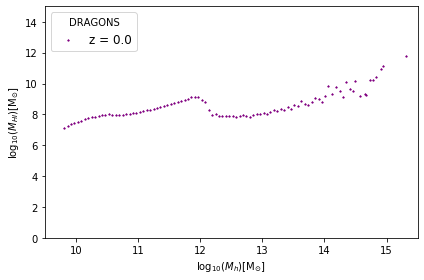

In [4]:
# Now plot the simulation for Cen, Sat and All and the Zwaan 2005 and Martin 2010 dataset on one fig
fig, ax = plt.subplots(1, 1)

label_z = ("z = " + redshift_used)

plot = ax.scatter(Mvir_mean, HIMass_median, color= "purple", marker= "*", s=2, label=label_z)  
ax.set_xlabel(r"$\log_{10}(M_{h}) [{\rm M_{\odot}}]$")
ax.set_ylabel(r"$\log_{10}(M_{HI}) [{\rm M_{\odot}}]$")
ax.set_ylim([0,15])
ax.set_xlim([9.5,15.5])
# Add the legend
plt.legend(title=("DRAGONS"),
           loc='upper left',
           ncol=5,
           fontsize=12)

# Finally save the figure as a PDF
plt.tight_layout()
nbins = str(nbins)
name_of_plot=("Alice_MHI_Mvir_" + nbins + "_scatter")
plt.savefig("plots/" + name_of_plot + ".pdf")

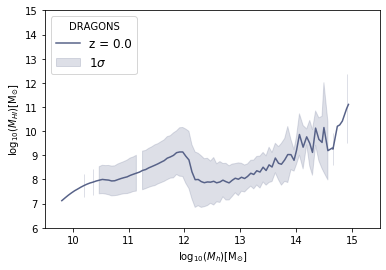

In [5]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel(r"$\log_{10}(M_{h}) [{\rm M_{\odot}}]$")
ax.set_ylabel(r"$\log_{10}(M_{HI}) [{\rm M_{\odot}}]$")
ax.set_ylim([6,15])
ax.set_xlim([9.5,15.5])
label_sigma = ("$1\sigma$")
color_used=np.random.rand(3,)
ax.plot(Mvir_mean, HIMass_median, color=color_used, label=label_z)
ax.fill_between(Mvir_mean, 
                HIMass_median - HIMass_std, 
                HIMass_median + HIMass_std, 
                alpha=0.2, color =color_used, label=label_sigma)

plt.legend(title=("DRAGONS"),
           loc='upper left',
           fontsize=12)

name_of_plot=("Alice_MHI_Mvir_" + nbins + "_shaded_z-" + redshift_used)
plt.savefig("plots/" + name_of_plot + ".pdf")